<a href="https://colab.research.google.com/github/Datkhoo25/Multilevel-Dynamic-Relation-Graph-Attention-Network-DR-GAT-/blob/main/Base_Model_4_MASS_GRU_(Residual)w_Dynamic_%2B_Fixed_GAT_%2B_HP(WS10)(IRR_MRR_20).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
import pandas as pd
import numpy as np
import pickle
import tensorflow as tf

!pip uninstall -y kerastuner
!pip install keras-tuner
import numpy as np
import keras_tuner as kt
from tqdm import tqdm
import matplotlib.pyplot as plt
!pip install numba
from numba import cuda
import time

import os
import random
# Set random seeds for reproducibility
def set_random_seeds(seed=42):
    np.random.seed(seed)
    random.seed(seed)
    tf.random.set_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)

set_random_seeds()
# Ensure deterministic operations
os.environ['TF_DETERMINISTIC_OPS'] = '1'
os.environ['TF_CUDNN_DETERMINISTIC'] = '1'
os.environ['OMP_NUM_THREADS'] = '1'
os.environ['TF_NUM_INTRAOP_THREADS'] = '1'
os.environ['TF_NUM_INTEROP_THREADS'] = '1'
os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'


tf.keras.utils.set_random_seed(42)
tf.config.experimental.enable_op_determinism()
# Though with all this step, tere are still controlled noise which actually can help with robustness of the model.
# https://github.com/NVIDIA/framework-reproducibility/blob/master/doc/d9m/README.md
# https://github.com/NVIDIA/framework-reproducibility/blob/master/doc/d9m/tensorflow.md

Mounted at /content/drive
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 9.4 MB/s eta 0:00:00


In [ ]:
# Set GPU memory limit and enable memory growth
def set_gpu_memory_limit(memory_limit):
    gpus = tf.config.list_physical_devices('GPU')
    if gpus:
        try:
            # Enable memory growth
            for gpu in gpus:
                tf.config.experimental.set_memory_growth(gpu, True)

            # Set memory limit
            tf.config.set_logical_device_configuration(
                gpus[0],
                [tf.config.LogicalDeviceConfiguration(memory_limit=memory_limit)]
            )
            print(f"Set GPU memory limit to {memory_limit} MB")
        except RuntimeError as e:
            print(e)

In [ ]:
file_path_train = f'/content/drive/MyDrive/Colab Notebooks/GNN/Input_data/final_preprocessed_train_complete.pkl'
with open(file_path_train, 'rb') as file:
    train_data = pickle.load(file)
print(f"Data has been loaded from {file_path_train}")

file_path_val = f'/content/drive/MyDrive/Colab Notebooks/GNN/Input_data/final_preprocessed_val_complete.pkl'
with open(file_path_val, 'rb') as file:
    val_data = pickle.load(file)
print(f"Data has been loaded from {file_path_val}")

file_path_test = f'/content/drive/MyDrive/Colab Notebooks/GNN/Input_data/final_preprocessed_test_complete.pkl'
with open(file_path_test, 'rb') as file:
    test_data = pickle.load(file)
print(f"Data has been loaded from {file_path_test}")

All_data_list = [train_data, val_data, test_data]

Data has been loaded from /content/drive/MyDrive/Colab Notebooks/GNN/Input_data/final_preprocessed_train_complete.pkl
Data has been loaded from /content/drive/MyDrive/Colab Notebooks/GNN/Input_data/final_preprocessed_val_complete.pkl
Data has been loaded from /content/drive/MyDrive/Colab Notebooks/GNN/Input_data/final_preprocessed_test_complete.pkl


In [ ]:
x_train = train_data[0][:, :, :, :2]
y_train = train_data[1][:]
print(x_train.shape, y_train.shape)

x_val = val_data[0][:, :, :, :2]
y_val = val_data[1][:]
print(x_val.shape, y_val.shape)

x_test = test_data[0][:, :, :, :2]
y_test = test_data[1][:]
print(x_test.shape, y_test.shape)

# Ensure data types are compatible with TensorFlow
x_train = tf.cast(x_train, dtype=tf.float32)
y_train = tf.cast(y_train, dtype=tf.float32)
x_val = tf.cast(x_val, dtype=tf.float32)
y_val = tf.cast(y_val, dtype=tf.float32)
x_test = tf.cast(x_test, dtype=tf.float32)
y_test = tf.cast(y_test, dtype=tf.float32)

(74, 551, 20, 2) (74, 551)
(24, 551, 20, 2) (24, 551)
(24, 551, 20, 2) (24, 551)


Loading Fixed Adj Matrices

In [ ]:
file_path_f_adj_matrix = f'/content/drive/MyDrive/Colab Notebooks/GNN/combined_adj_matrix.pkl'
with open(file_path_f_adj_matrix, 'rb') as file:
    f_adj_matrix = pickle.load(file)

print(f_adj_matrix.keys())
print(f_adj_matrix['total_list_of_property'])
relation_list = f_adj_matrix['total_list_of_property']

relation_list_w = relation_list[0:-1]
adj_matrices_wiki = []
for i in relation_list[0:-1]:
  print("The relation is", i, "in np array form")
  # print(f_adj_matrix['adj_matrices'][i])
  adj_matrices_wiki.append(f_adj_matrix['adj_matrices'][i])


print("The relation is", relation_list[-1])
relation_list_i = [relation_list[-1]]
adj_matrices_industry = [f_adj_matrix['adj_matrices'][relation_list[-1]]]

dict_keys(['lookup_dict', 'total_list_of_property', 'adj_matrices'])
['followsTicker', 'subsidiaryTicker', 'parentTicker', 'ownedByTicker', 'ownerOfTicker', 'industryLabel', 'legalformLabel', 'founded_byLabel', 'prod_mat_producedLabel', 'complies_withLabel', 'GISC_industry']
The relation is followsTicker in np array form
The relation is subsidiaryTicker in np array form
The relation is parentTicker in np array form
The relation is ownedByTicker in np array form
The relation is ownerOfTicker in np array form
The relation is industryLabel in np array form
The relation is legalformLabel in np array form
The relation is founded_byLabel in np array form
The relation is prod_mat_producedLabel in np array form
The relation is complies_withLabel in np array form
The relation is GISC_industry


In [ ]:
len(adj_matrices_wiki[0].shape)

2

Loading Dynamic Adj Matrices

In [ ]:
train_filter_matrix = All_data_list[0][4]
val_filter_matrix = All_data_list[1][4]  #e.g. val_filter_martrix['Q1'], val_filter_martrix['median']
test_filter_matrix = All_data_list[2][4]
print(test_filter_matrix['median'].shape) #Should output (24, 551)


train_dyn_adj_matrices = All_data_list[0][5]['adj_matrices']
val_dyn_adj_matrices = All_data_list[1][5]['adj_matrices'] #e.g. val_dyn_adj_matrices['Pairwise movement short term'],  val_dyn_adj_matrices[''Pairwise movement long term']
test_dyn_adj_matrices = All_data_list[2][5]['adj_matrices']

print(val_dyn_adj_matrices.keys())
print(val_dyn_adj_matrices['MASS long term'].shape) #Should output (24, 551, 551)

(24, 551)
dict_keys(['DTW long term', 'Pairwise movement long term', 'DTW short term', 'Pairwise movement short term', 'MASS long term', 'MASS short term'])
(24, 551, 551)


In [ ]:
def compute_irr_top20(predictions, ground_truth, sample_weight=None):
    top20_indices = tf.math.top_k(predictions, k=20).indices
    top20_returns = tf.gather(ground_truth, top20_indices, batch_dims=1)
    irr = tf.reduce_mean(top20_returns)
    return irr

def pointwise_regression_loss(predictions, targets, sample_weight=None):
    point_wise_loss = tf.reduce_mean(tf.square(predictions - targets), axis=1)
    total_loss = tf.reduce_sum(point_wise_loss)
    return total_loss

def compute_mrr_top20(predictions, ground_truth, sample_weight=None):
    top20 = tf.math.top_k(predictions, k=20)
    top20_indices = top20.indices
    top20_ground_truth = tf.gather(ground_truth, top20_indices, batch_dims=1)
    relevance_mask = tf.cast(top20_ground_truth > 0, tf.float32)  # Shape: [batch_size, 10]
    positions = tf.range(1, 21, dtype=tf.float32)
    positions = tf.reshape(positions, (1, -1))
    modified_positions = tf.where(relevance_mask > 0, positions, tf.fill(tf.shape(positions), 21.0))
    first_relevant_position = tf.reduce_min(modified_positions, axis=1)  # Shape: [batch_size]
    reciprocal_rank = tf.where(first_relevant_position <= 20, 1.0 / first_relevant_position, 0.0)
    overall_mrr = tf.reduce_mean(reciprocal_rank)
    return overall_mrr

Directly run the full thing with HP.

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import LeakyReLU, Dense
from tensorflow.keras.regularizers import l2
import kerastuner as kt
import gc

tf.config.run_functions_eagerly(False)
# tf.config.run_functions_eagerly(False) setting controls whether functions decorated with @tf.function

# Set GPU memory limit and enable memory growth
def set_gpu_memory_limit(memory_limit):
    gpus = tf.config.list_physical_devices('GPU')
    if gpus:
        try:
            # Enable memory growth
            for gpu in gpus:
                tf.config.experimental.set_memory_growth(gpu, True)

            # Set memory limit
            tf.config.set_logical_device_configuration(
                gpus[0],
                [tf.config.LogicalDeviceConfiguration(memory_limit=memory_limit)]
            )
            print(f"Set GPU memory limit to {memory_limit} MB")
        except RuntimeError as e:
            print(e)

# Define the GAT model and other necessary classes/functions
class MultiHeadGATLayer(tf.keras.layers.Layer):
    def __init__(self, gru_units, num_heads, head_dim, adj_matrices):
        super(MultiHeadGATLayer, self).__init__()
        self.gru_units = gru_units
        self.num_heads = num_heads
        self.head_dim = head_dim
        self.num_relations = len(adj_matrices)
        self.adj_matrices = [tf.cast(adj, dtype=tf.float32) for adj in adj_matrices]
        self.gat_output_shape = None

        # Create weights for each relation and each head
        self.W1 = [
            [self.add_weight(
                shape=(gru_units, self.head_dim),
                initializer=tf.keras.initializers.RandomNormal(seed=42),
                trainable=True,
                name=f"W1_rel{r}_head{h}"
            ) for h in range(num_heads)]
            for r in range(self.num_relations)
        ]

        # Create an attention vector for each relation and each head
        self.r = [
            [self.add_weight(
                shape=(2 * self.head_dim, 1),
                initializer=tf.keras.initializers.RandomNormal(seed=42),
                trainable=True,
                name=f"r_rel{r}_head{h}"
            ) for h in range(self.num_heads)]
            for r in range(self.num_relations)
        ]

        self.leaky_relu = LeakyReLU(negative_slope=0.2)

    def build(self, input_shape):
        self.num_stocks = input_shape[1]
        super(MultiHeadGATLayer, self).build(input_shape)

    def call(self, inputs, adj_matrices=None):
        if adj_matrices is not None:
            self.adj_matrices = [tf.cast(adj, dtype=tf.float32) for adj in adj_matrices]

        head_outputs = []
        batch_size = tf.shape(inputs)[0]

        for r in range(self.num_relations):
            relation_head_outputs = []
            for h in range(self.num_heads):
                W1_rh = self.W1[r][h]
                r_rh = self.r[r][h]

                h_i = tf.matmul(inputs, W1_rh)
                h_j = tf.expand_dims(h_i, axis=2)
                h_j = tf.tile(h_j, [1, 1, self.num_stocks, 1])
                h_i_expanded = tf.expand_dims(h_i, axis=1)
                h_i_expanded = tf.tile(h_i_expanded, [1, self.num_stocks, 1, 1])
                concat_features = tf.concat([h_i_expanded, h_j], axis=-1)
                concat_features_reshaped = tf.reshape(concat_features, [-1, 2 * self.head_dim])

                scores = self.leaky_relu(tf.matmul(concat_features_reshaped, r_rh))
                scores = tf.reshape(scores, [batch_size, self.num_stocks, self.num_stocks])

                if len(self.adj_matrices[r].shape) == 2:
                    adj_matrix = tf.expand_dims(self.adj_matrices[r], axis=0)
                    adj_matrix = tf.tile(adj_matrix, [batch_size, 1, 1])
                else:
                    adj_matrix = self.adj_matrices[r]

                masked_scores = tf.where(adj_matrix > 0, scores, -1e9 * tf.ones_like(scores))
                attention_weights = tf.nn.softmax(masked_scores, axis=-1)
                output = tf.matmul(attention_weights, h_i)
                relation_head_outputs.append(output)

            relation_output = tf.concat(relation_head_outputs, axis=-1)
            head_outputs.append(relation_output)

        final_output = tf.reduce_mean(tf.stack(head_outputs, axis=-1), axis=-1)
        self.gat_output_shape = final_output.shape
        return tf.nn.relu(final_output)

    def compute_output_shape(self, input_shape):
        return self.gat_output_shape


class MultiStockGRUModel(tf.keras.Model):
    def __init__(self, gru_units, dense_units, dense_units2, num_heads, head_dim,
                 adj_matrices_w, adj_matrices_i, number_of_layers, dense_initializer, dense_activation, l2_lambda=0.005):
        super(MultiStockGRUModel, self).__init__()
        self.gru_units = gru_units
        self.num_dense_layers = number_of_layers
        self.l2_lambda = l2_lambda
        self.gru_layers = []

        # Build the dense layers stack with kernel_regularizer added for long-term path
        self.dense_layers_lt = []

        for _ in range(number_of_layers - 1):
            if dense_activation == 'leaky_relu':
                self.dense_layers_lt.append(
                    tf.keras.Sequential([
                        Dense(dense_units, activation=None, kernel_initializer=dense_initializer,
                              kernel_regularizer=l2(l2_lambda)),
                        LeakyReLU(negative_slope=0.2)
                    ])
                )
            else:
                self.dense_layers_lt.append(
                    Dense(dense_units, activation=dense_activation, kernel_initializer=dense_initializer,
                          kernel_regularizer=l2(l2_lambda))
                )
        # Final dense layer for long-term path
        self.dense_layers_lt.append(
            Dense(dense_units2, activation=None, kernel_regularizer=l2(l2_lambda))
        )

        # Build the dense layers stack with kernel_regularizer added for short-term path
        self.dense_layers_st = []

        for _ in range(number_of_layers - 1):
            if dense_activation == 'leaky_relu':
                self.dense_layers_st.append(
                    tf.keras.Sequential([
                        Dense(dense_units, activation=None, kernel_initializer=dense_initializer,
                              kernel_regularizer=l2(l2_lambda)),
                        LeakyReLU(negative_slope=0.2)
                    ])
                )
            else:
                self.dense_layers_st.append(
                    Dense(dense_units, activation=dense_activation, kernel_initializer=dense_initializer,
                          kernel_regularizer=l2(l2_lambda))
                )
        # Final dense layer for short-term path
        self.dense_layers_st.append(
            Dense(dense_units2, activation=None, kernel_regularizer=l2(l2_lambda))
        )

        # Initialize your custom GAT layers with dummy adjacency matrices
        self.gat_layer_w = MultiHeadGATLayer(gru_units, num_heads, head_dim, adj_matrices_w)
        self.gat_layer_i = MultiHeadGATLayer(gru_units, num_heads, head_dim, adj_matrices_i)
        self.gat_layer_lt = MultiHeadGATLayer(gru_units, num_heads, head_dim, [tf.ones_like(adj_matrices_i[0])])
        self.gat_layer_st = MultiHeadGATLayer(gru_units, num_heads, head_dim, [tf.ones_like(adj_matrices_i[0])])

    def build(self, input_shape):
        self.num_stocks = input_shape[1]
        self.gru_layers = [
            tf.keras.layers.GRU(self.gru_units, return_sequences=False, name=f"GRU_Stock_{i}")
            for i in range(self.num_stocks)
        ]

    def call(self, inputs, training=False):
        x, adj_matrices_lt, adj_matrices_st, filter_matrix = inputs
        batch_size = tf.shape(x)[0]

        stock_outputs = []
        for i in range(self.num_stocks):
            stock_input = x[:, i, :, :]
            stock_output = self.gru_layers[i](stock_input)
            # print(f"Output of GRU_Stock_{i} shape: {stock_output.shape}")
            stock_outputs.append(stock_output)

        fused_output = tf.stack(stock_outputs, axis=1)
        # print(f"Fused output shape: {fused_output.shape}")

        gat_output_w = self.gat_layer_w(fused_output)
        # print(f"GAT wiki output shape: {gat_output_w.shape}")

        gat_output_i = self.gat_layer_i(fused_output)
        # print(f"GAT industry output shape: {gat_output_i.shape}")

        self.gat_layer_lt.adj_matrices = [tf.cast(adj, dtype=tf.float32) for adj in adj_matrices_lt]
        gat_output_lt = self.gat_layer_lt(fused_output)
        # print(f"GAT lt output shape: {gat_output_lt.shape}")

        self.gat_layer_st.adj_matrices = [tf.cast(adj, dtype=tf.float32) for adj in adj_matrices_st]
        gat_output_st = self.gat_layer_st(fused_output)
        # print(f"GAT st output shape: {gat_output_st.shape}")

        # Combine the GAT embeddings for long-term path (concatenation)
        gat_combined_lt = tf.concat([gat_output_w, gat_output_i, gat_output_lt], axis=-1)
        # print(f"GAT combined long term shape: {gat_combined_lt.shape}")

        # Dense layer to combine GAT embeddings (dense layer operation) for long-term path
        dense_output_lt = gat_combined_lt
        dense_output_lt = self.dense_layers_lt[0](dense_output_lt)
        dense_output_lt= tf.concat([dense_output_lt,fused_output], axis=-1)  # Concatanating residual connection after one dense layer


        for layer in self.dense_layers_lt[1:-1]:
            dense_output_lt = layer(dense_output_lt)
            # print(f"Dense layer long term intermediate output shape: {dense_output_lt.shape}")

        dense2_output_lt = self.dense_layers_lt[-1](dense_output_lt)
        # print(f"Final dense long term output shape: {dense2_output_lt.shape}")

        # Dense layer for short-term path
        dense_output_st = gat_output_st

        dense_output_st = self.dense_layers_st[0](dense_output_st)
        dense_output_st= tf.concat([dense_output_st,fused_output], axis=-1)  # Concatanating residual connection after one dense layer


        for layer in self.dense_layers_st[1:-1]:
            dense_output_st = layer(dense_output_st)
            # print(f"Dense layer short term intermediate output shape: {dense_output_st.shape}")

        dense2_output_st = self.dense_layers_st[-1](dense_output_st)
        # print(f"Final dense short term output shape: {dense2_output_st.shape}")

        # Filter mechanism to select the prediction
        filter_matrix_expanded = tf.expand_dims(filter_matrix, axis=-1)
        final_output = tf.where(filter_matrix_expanded == 1, dense2_output_st, dense2_output_lt)
        # print(f"Final output shape after filter: {final_output.shape}")

        return tf.squeeze(final_output, axis=-1)

class CustomMetric(tf.keras.metrics.Metric):
    def __init__(self, metric_fn, name, **kwargs):
        super(CustomMetric, self).__init__(name=name, **kwargs)
        self.metric_fn = metric_fn
        self.result_value = self.add_weight(name=f"{name}_value", initializer="zeros")
        self.count = self.add_weight(name=f"{name}_count", initializer="zeros")

    @tf.function
    def update_state(self, y_true, y_pred, **kwargs):
        value = self.metric_fn(y_pred, y_true, **kwargs)
        self.result_value.assign_add(value)
        self.count.assign_add(1.0)

    @tf.function
    def result(self):
        return self.result_value / tf.maximum(self.count, 1.0)

    @tf.function
    def reset_states(self):
        self.result_value.assign(0.0)
        self.count.assign(0.0)

metrics = [
    CustomMetric(pointwise_regression_loss, name="pointwise_regression_loss"),
    CustomMetric(compute_irr_top20, name="compute_irr_top20"),
    CustomMetric(compute_mrr_top20, name="compute_mrr_top20")
]

@tf.function
def optimized_custom_loss_function(y_true, y_pred, model, alpha=1.0, lambda_=0.01):
    pointwise_loss = tf.reduce_mean(tf.square(y_pred - y_true))
    batch_size = tf.shape(y_true)[0]
    y_pred_diff = tf.expand_dims(y_pred, 2) - tf.expand_dims(y_pred, 1)
    y_true_diff = tf.expand_dims(y_true, 2) - tf.expand_dims(y_true, 1)
    pairwise_loss = tf.reduce_sum(tf.maximum(0.0, -y_pred_diff * y_true_diff))
    pairwise_loss = alpha * pairwise_loss / tf.cast(batch_size, tf.float32)
    l2_loss = lambda_ * tf.add_n([tf.nn.l2_loss(v) for v in model.trainable_variables])
    loss = pointwise_loss + pairwise_loss + l2_loss
    return loss

adj_matrices_lt_train = [train_dyn_adj_matrices['MASS long term']]
adj_matrices_st_train = [train_dyn_adj_matrices['MASS short term']]
filter_matrix_train = train_filter_matrix['median']

adj_matrices_lt_val = [val_dyn_adj_matrices['MASS long term']]
adj_matrices_st_val = [val_dyn_adj_matrices['MASS short term']]
filter_matrix_val = val_filter_matrix['median']

adj_matrices_lt_test = [test_dyn_adj_matrices['MASS long term']]
adj_matrices_st_test = [test_dyn_adj_matrices['MASS short term']]
filter_matrix_test = test_filter_matrix['median']

# Prepare the data for training
train_data = [x_train, adj_matrices_lt_train, adj_matrices_st_train, filter_matrix_train]
val_data = [x_val, adj_matrices_lt_val, adj_matrices_st_val, filter_matrix_val]
test_data = [x_test, adj_matrices_lt_test, adj_matrices_st_test, filter_matrix_test]



class CustomHyperModel(kt.HyperModel):
    def build(self, hp):
        gru_units = hp.Choice('gru_units', [24, 48])
        dense_units = hp.Choice('dense_units', [24, 48])
        head_dim = hp.Choice('head_dim', [7, 10])
        num_heads = hp.Choice('num_heads', [8, 10])
        dense_units2 = 1
        number_of_layers = hp.Choice('number_of_layers', [2, 3])
        dense_initializer = hp.Choice("dense_initializer", ['glorot_uniform', 'he_normal', 'random_normal'])
        dense_activation = hp.Choice("dense_activation", ['linear', 'relu', 'leaky_relu'])
        alpha = hp.Choice('alpha', [2.0, 1.0])
        lambda_ = hp.Choice('lambda', [0.05])


        # Initialize model with adjacency matrices (assumed to be defined)
        model = MultiStockGRUModel(
            gru_units, dense_units, dense_units2, num_heads, head_dim,
            adj_matrices_wiki, adj_matrices_industry,
            number_of_layers, dense_initializer, dense_activation,  l2_lambda=0.005)

        model.build((None, x_train.shape[1], x_train.shape[2], x_train.shape[3]))


        optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
        model.compile(optimizer=optimizer,
                      loss=lambda y_true, y_pred: optimized_custom_loss_function(y_true, y_pred, model, alpha=alpha, lambda_=lambda_),
                      metrics=metrics)
        return model

    @tf.function
    def run_trial(self, trial, x_train, y_train, x_val, y_val, epochs, batch_size, **kwargs):
        try:
            # Build and compile the model
            model = self.build(trial.hyperparameters)
            # Define early stopping callback
            early_stopping = tf.keras.callbacks.EarlyStopping(
                monitor='val_compute_irr_top20',  # Metric to monitor
                patience=1,          # Number of epochs with no improvement after which training will be stopped
                restore_best_weights=True  # Restore model weights from the epoch with the best value of the monitored metric
            )
            # Fit the model with early stopping
            history = model.fit(
                train_data, y_train,
                validation_data=(val_data, y_val),
                epochs=epochs,
                batch_size=batch_size,
                callbacks=[early_stopping],  # Add early stopping callback
                **kwargs
            )
        finally:
            # Ensure CUDA device is reset after each trial
            tf.keras.backend.clear_session()
            gc.collect()
        return history


# Set GPU memory limit to 14.8 GB (14800 MB) and enable memory growth
set_gpu_memory_limit(14800)

tuner = kt.RandomSearch(
    CustomHyperModel(),
    objective=kt.Objective('val_compute_irr_top20', direction='max'),
    max_trials=150,  # Run the specified number of trials
    executions_per_trial=2,
    directory='/content/drive/MyDrive/Colab Notebooks/GNN/Baseline 4: GAT with Fixed and Long Short Term Dynamic Graph/',
    project_name=f'BSM4_HP_(LT_ST_Wiki n Ind)(med_mass)(IRR_MRR20)_1')

# Start hyperparameter search (adjacency matrices are passed during model building)
tuner.search(
    train_data,
    y_train,
    epochs=6,
    validation_data=(val_data, y_val),
    verbose=1,  # Ensure verbose is set to 1 to print epoch status
    batch_size=2)


class CustomModel(tf.keras.Model):
    def __init__(self, loaded_model):
        super(CustomModel, self).__init__()
        self.loaded_model = loaded_model

    def call(self, inputs):
        return self.loaded_model.signatures['serving_default'](inputs)['output_0']

Trial 150 Complete [00h 30m 39s]
val_compute_irr_top20: 0.0010136926430277526

Best val_compute_irr_top20 So Far: 0.0032768010860309005
Total elapsed time: 8d 04h 58m 42s


In [ ]:
# Extract best hyperparameters from the tuner
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

# Retrain the model with the best hyperparameters
set_random_seeds()  # Ensure reproducibility

model = CustomHyperModel().build(best_hps)

#Start the time
start_time = time.time()

history = model.fit(
    train_data, y_train,
    validation_data=(val_data, y_val),
    epochs=6,
    batch_size=2,
    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=1, restore_best_weights=True)]
)

# Stop counting time
end_time = time.time()

# Calculate elapsed time
elapsed_time = end_time - start_time


test_results = model.evaluate(test_data, y_test, batch_size=2)
print(f"Test Results: {test_results}")

Epoch 1/6
37/37 ━━━━━━━━━━━━━━━━━━━━ 645s 3s/step - compute_irr_top20: 0.0023 - compute_mrr_top20: 0.6976 - loss: 2690.5803 - pointwise_regression_loss: 0.2896 - val_compute_irr_top20: 7.5675e-04 - val_compute_mrr_top20: 0.6201 - val_loss: 898.1062 - val_pointwise_regression_loss: 0.0569
Epoch 2/6
37/37 ━━━━━━━━━━━━━━━━━━━━ 52s 1s/step - compute_irr_top20: 0.0079 - compute_mrr_top20: 0.7924 - loss: 774.1196 - pointwise_regression_loss: 0.0381 - val_compute_irr_top20: -4.5719e-04 - val_compute_mrr_top20: 0.5899 - val_loss: 556.6310 - val_pointwise_regression_loss: 0.0251
Epoch 3/6
37/37 ━━━━━━━━━━━━━━━━━━━━ 52s 1s/step - compute_irr_top20: 0.0116 - compute_mrr_top20: 0.8538 - loss: 461.9556 - pointwise_regression_loss: 0.0167 - val_compute_irr_top20: 0.0023 - val_compute_mrr_top20: 0.6306 - val_loss: 425.7115 - val_pointwise_regression_loss: 0.0172
Epoch 4/6
37/37 ━━━━━━━━━━━━━━━━━━━━ 52s 1s/step - compute_irr_top20: 0.0128 - compute_mrr_top20: 0.7869 - loss: 343.7675 - pointwise_regres

Best Hyperparameter Combination:
GRU Units: 48
Dense Units: 24
Head Dim: 10
Num Heads: 10
Number of Layers: 3
Dense Initializer: glorot_uniform
Dense Activation: relu
Alpha: 1.0
Lambda: 0.05


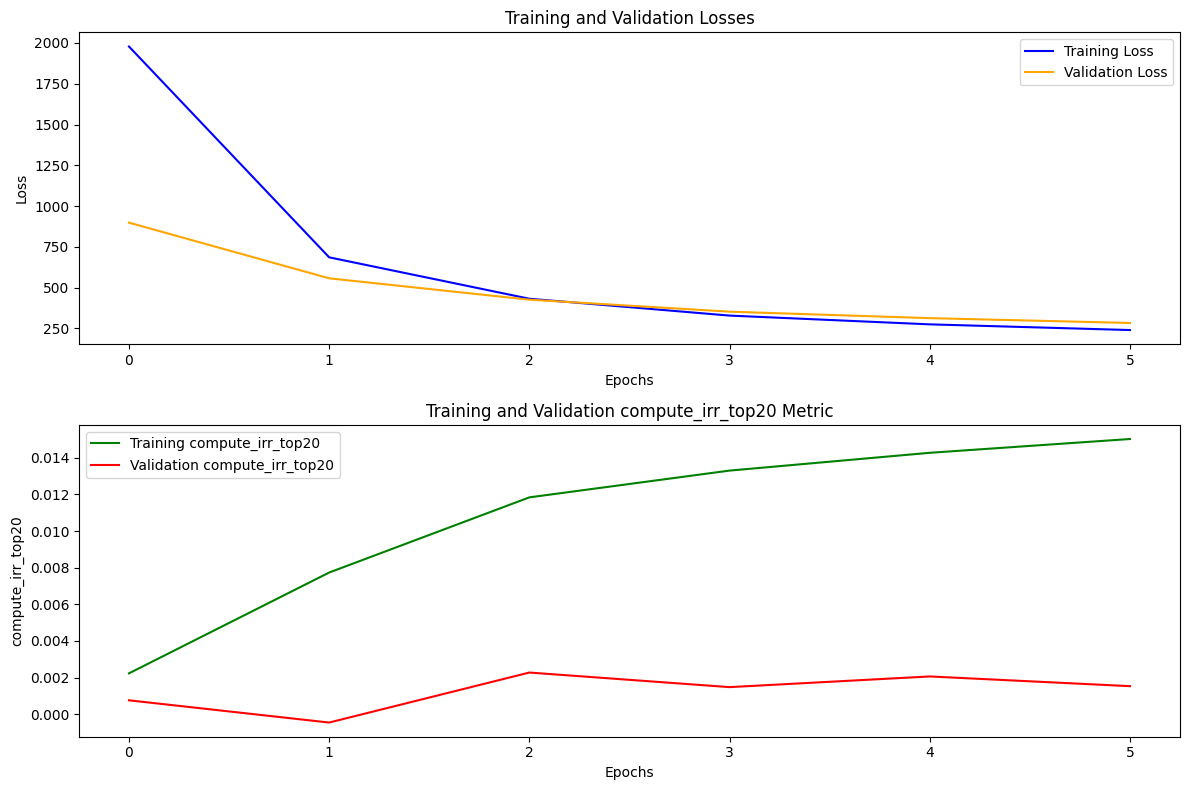

In [ ]:
# Print the best hyperparameter combination (for your reference)
print("Best Hyperparameter Combination:")
print(f"GRU Units: {best_hps.get('gru_units')}")
print(f"Dense Units: {best_hps.get('dense_units')}")
print(f"Head Dim: {best_hps.get('head_dim')}")
print(f"Num Heads: {best_hps.get('num_heads')}")
print(f"Number of Layers: {best_hps.get('number_of_layers')}")
print(f"Dense Initializer: {best_hps.get('dense_initializer')}")
print(f"Dense Activation: {best_hps.get('dense_activation')}")
print(f"Alpha: {best_hps.get('alpha')}")
print(f"Lambda: {best_hps.get('lambda')}")

# Hardcode the metric names to get all results from history
train_loss = history.history.get('loss', [])
val_loss = history.history.get('val_loss', [])
train_pointwise_regression_loss = history.history.get('pointwise_regression_loss', [])
val_pointwise_regression_loss = history.history.get('val_pointwise_regression_loss', [])
train_compute_irr_top20 = history.history.get('compute_irr_top20', [])
val_compute_irr_top20 = history.history.get('val_compute_irr_top20', [])
train_compute_mrr_top20 = history.history.get('compute_mrr_top20', [])
val_compute_mrr_top20 = history.history.get('val_compute_mrr_top20', [])

# Save the results to a dictionary
results = {
    'best_hyperparameters': {
        'gru_units': best_hps.get('gru_units'),
        'dense_units': best_hps.get('dense_units'),
        'head_dim': best_hps.get('head_dim'),
        'num_heads': best_hps.get('num_heads'),
        'number_of_layers': best_hps.get('number_of_layers'),
        'dense_initializer': best_hps.get('dense_initializer'),
        'dense_activation': best_hps.get('dense_activation'),
        'alpha': best_hps.get('alpha'),
        'lambda': best_hps.get('lambda')
    },
    'train_loss': train_loss,
    'val_loss': val_loss,
    'test_loss': test_results[0],
    'train_metrics': {
        'pointwise_regression_loss': train_pointwise_regression_loss,
        'compute_irr_top20': train_compute_irr_top20,
        'compute_mrr_top20': train_compute_mrr_top20
    },
    'val_metrics': {
        'val_pointwise_regression_loss': val_pointwise_regression_loss,
        'val_compute_irr_top20': val_compute_irr_top20,
        'val_compute_mrr_top20': val_compute_mrr_top20
    },
    'test_metrics': {
        'pointwise_regression_loss': test_results[1],
        'compute_irr_top20': test_results[2],
        'compute_mrr_top20': test_results[3]
    },
    'training_time': elapsed_time
}

# Save the dictionary to a pickle file with a name based on the tuner project name
pickle_filename = f"/content/drive/MyDrive/Colab Notebooks/GNN/Baseline 4: GAT with Fixed and Long Short Term Dynamic Graph/BSM4_HP_(LT_ST_Wiki n Ind)(med_mass)(IRR_MRR20)_1.pkl"
with open(pickle_filename, "wb") as f:
    pickle.dump(results, f)



# Plot the training and validation losses and compute_irr_top20 metric
plt.figure(figsize=(12, 8))

# Subplot for Loss
plt.subplot(2, 1, 1)
plt.plot(train_loss, label='Training Loss', color='blue')
plt.plot(val_loss, label='Validation Loss', color='orange')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Losses')
plt.legend()

# Subplot for compute_irr_top20
plt.subplot(2, 1, 2)
plt.plot(train_compute_irr_top20, label='Training compute_irr_top20', color='green')
plt.plot(val_compute_irr_top20, label='Validation compute_irr_top20', color='red')
plt.xlabel('Epochs')
plt.ylabel('compute_irr_top20')
plt.title('Training and Validation compute_irr_top20 Metric')
plt.legend()

plt.tight_layout()
plt.show()